# CNN Tuning - Nombre de filtres - Extrême haut, altération des couches cachées

## Objectif
L'objectif de ce notebook est de tester notre CNN en modifiant le nombre de filtres par couche de convolution avec des valeurs très hautes comparées à la référence.

## Hypothèses
Les hypothèses quant aux résultats attendus sont les suivantes :
- Une précision beaucoup plus faible que celle du CNN du template

## Etapes de la démarche
1. Dans la méthode create_model(), change le nombre de filtres par couches de convolution
2. Tester le modèle sur le jeu de données
3. Calculer les métriques de performance
4. Comparer les résultats avec les résultats du CNN

## Conclusion
Les résultats obtenus sont les suivants :
- La précision du modèle modifiée est similaire au modèle d'origine (0.92)
- Le temps d'entrainement est fortement rallongé

Le changement du nombre de filtres vers un extrême haut n'a pas d'impact sur la précision du modèle et augmente fortement le temps d'entrainement. Pour notre cas d'étude, cela remet en cause l'utilité d'avoir autant de filtres par couche de convolution.

In [30]:
# Check that GPU is used
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
from PIL import Image
import os
import numpy as np

# Define the folders where your data is stored
train_folder = 'train'
test_folder = 'test'
val_folder = 'val'

# Define the subfolders within each folder where the images are stored
subfolders = ['NORMAL', 'PNEUMONIA']

# Define the size of the images you want to resize your images to
img_width, img_height = 128, 128

In [32]:
# Function to load and resize images from a folder
def load_images_from_folder(folder, limit_per_subfolder=None):
    X = []
    y = []
    for subfolder in subfolders:
        folder_path = os.path.join(folder, subfolder)
        if limit_per_subfolder:
            # Get amount of random filenames from the folder
            filenames = np.random.choice(os.listdir(folder_path), limit_per_subfolder, replace=False)
        else:
            filenames = os.listdir(folder_path)
        for filename in filenames:
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            # Resize the image to the desired size
            img = img.resize((img_width, img_height))

            # Convert RGB image to grayscale
            img = img.convert('L')

            # Convert the image to a NumPy array and append it to X
            img = np.array(img)
            X.append(img)

            # Append the corresponding label to y
            y.append(subfolders.index(subfolder))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [33]:
# Generate augmented for the training set
from common.data_augmentation import generate_augmented_images
generate_augmented_images(train_folder, 'NORMAL', image_size=(img_width, img_height))
generate_augmented_images(train_folder, 'PNEUMONIA', image_size=(img_width, img_height))

Found 1341 images belonging to 1 classes.
Additional count of images to generate: 0
Given NORMAL count: 1341
Augmented NORMAL count: 5000
Found 3874 images belonging to 1 classes.
Additional count of images to generate: 0
Given PNEUMONIA count: 3874
Augmented PNEUMONIA count: 5000


In [34]:
# Load the training data
# Get min value between the number of normal images and the number of pneumonia images
train_folder = f"{train_folder}_augmented"
min_images = min(len(os.listdir(os.path.join(train_folder, subfolders[0]))), len(os.listdir(os.path.join(train_folder, subfolders[1]))))
X_train, y_train = load_images_from_folder(train_folder, min_images)

# Load the test data
X_test, y_test = load_images_from_folder(test_folder)

# Load the validation data
X_val, y_val = load_images_from_folder(val_folder)

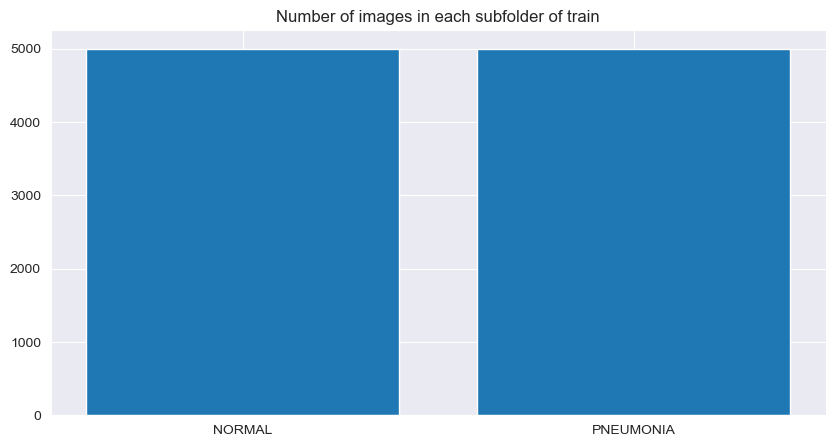

In [35]:
# Make a matplot figure to show how many images are in each subfolder of train
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(os.listdir(os.path.join(train_folder, subfolder))) for subfolder in subfolders])
plt.title('Number of images in each subfolder of train')
plt.show()

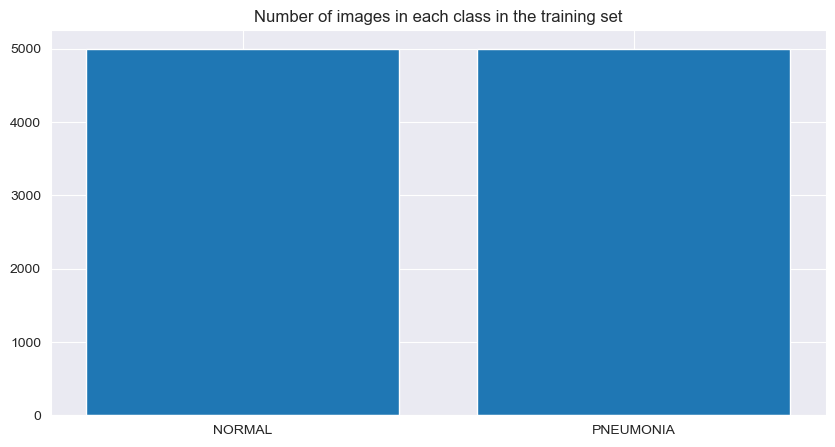

In [36]:
# Make a matplot figure to show how many images if each class in the training set
plt.figure(figsize=(10, 5))
plt.bar(subfolders, [len(y_train[y_train == i]) for i in range(len(subfolders))])
plt.title('Number of images in each class in the training set')
plt.show()

In [37]:
# Normalize the pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
X_val = X_val.astype('float32') / 255

X_train = X_train.reshape(len(X_train), img_width, img_height, 1)
X_test = X_test.reshape(len(X_test), img_width, img_height, 1)
X_val = X_val.reshape(len(X_val), img_width, img_height, 1)

(128, 128, 1)


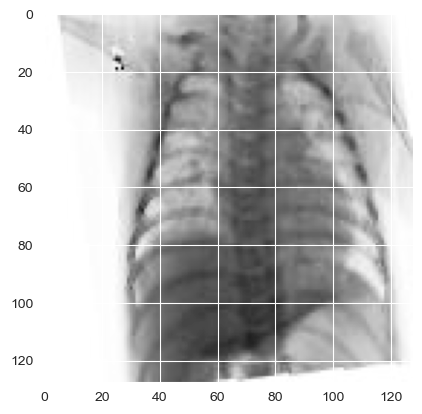

In [38]:
single_image = X_train[np.random.randint(len(X_train))]
print(single_image.shape)
plt.imshow(single_image, cmap='Greys')

In [39]:
# Define model metrics
from keras.metrics import AUC

metrics = [
    "accuracy",
    AUC(name='auc')
]

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model architecture
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=128, kernel_size=(3,3), input_shape=(img_width, img_height, 1), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=1024, kernel_size=(3,3), activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation="sigmoid"))

    # compile the model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=metrics)

    return model

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

In [42]:
# Cross validation
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator

# Define the number of folds for cross-validation
n_splits = 10
epochs = 7
batch_size = 64

# Initialize KFold with the number of folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define lists to store the evaluation scores for each fold
accuracy_scores = []
histories = []
models = []

# Iterate through each fold and train/evaluate the model
for train_idx, val_idx in kf.split(X_train, y_train):
    # Split the data into training and validation sets for this fold
    X_train_fold, y_train_fold = X_train[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train[val_idx], y_train[val_idx]

    # Create an instance of ImageDataGenerator to generate your image data
    datagen = ImageDataGenerator()

    # Create generators for training and validation data
    train_generator = datagen.flow(x=X_train_fold, y=y_train_fold, batch_size=batch_size)
    valid_generator = datagen.flow(x=X_val_fold, y=y_val_fold, batch_size=batch_size)

    # Create instance of the model for this fold and train it
    model = create_model()

    # Train your model on the training data for this fold
    history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
    histories.append(history.history)

    models.append(model)


Epoch 1/7
141/141 [==============================] - 35s 147ms/step - loss: 0.6776 - accuracy: 0.5517 - auc: 0.5899 - val_loss: 0.6103 - val_accuracy: 0.6690 - val_auc: 0.7466
Epoch 2/7
141/141 [==============================] - 16s 114ms/step - loss: 0.5028 - accuracy: 0.7616 - auc: 0.8356 - val_loss: 0.3556 - val_accuracy: 0.8590 - val_auc: 0.9311
Epoch 3/7
141/141 [==============================] - 16s 111ms/step - loss: 0.3178 - accuracy: 0.8712 - auc: 0.9383 - val_loss: 0.2734 - val_accuracy: 0.9030 - val_auc: 0.9576
Epoch 4/7
141/141 [==============================] - 15s 104ms/step - loss: 0.2493 - accuracy: 0.9039 - auc: 0.9614 - val_loss: 0.3411 - val_accuracy: 0.8830 - val_auc: 0.9609
Epoch 5/7
141/141 [==============================] - 15s 103ms/step - loss: 0.2043 - accuracy: 0.9246 - auc: 0.9733 - val_loss: 0.2315 - val_accuracy: 0.9130 - val_auc: 0.9737
Epoch 6/7
141/141 [==============================] - 15s 105ms/step - loss: 0.2023 - accuracy: 0.9260 - auc: 0.9740 - va

In [43]:
# Get accuracy scores for each fold (train and validation)
loss = []
acc = []
val_loss = []
val_acc = []

for history in histories:
    loss.append(np.mean(history["loss"]))
    acc.append(np.mean(history["accuracy"]))
    val_loss.append(np.mean(history["val_loss"]))
    val_acc.append(np.mean(history["val_accuracy"]))

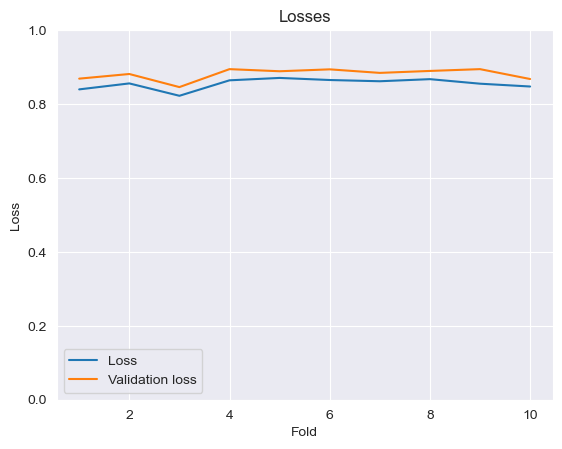

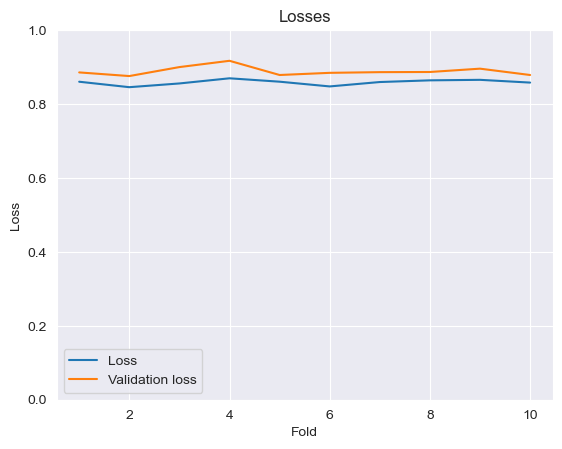

In [44]:
# Plot loss and validation loss per fold
import matplotlib.pyplot as plt
plt.title('Losses')
plt.plot(range(1, len(acc)+1), acc, label='Loss')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.show()

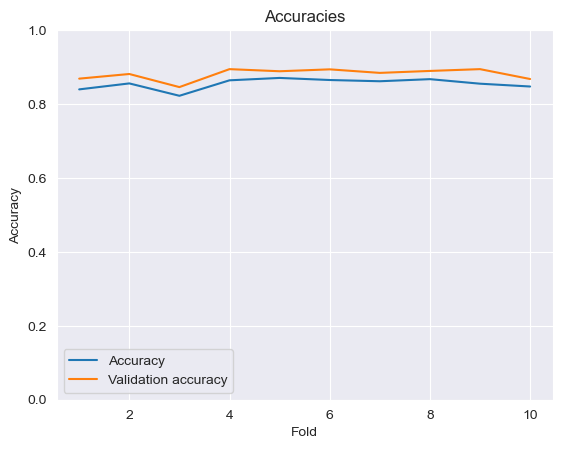

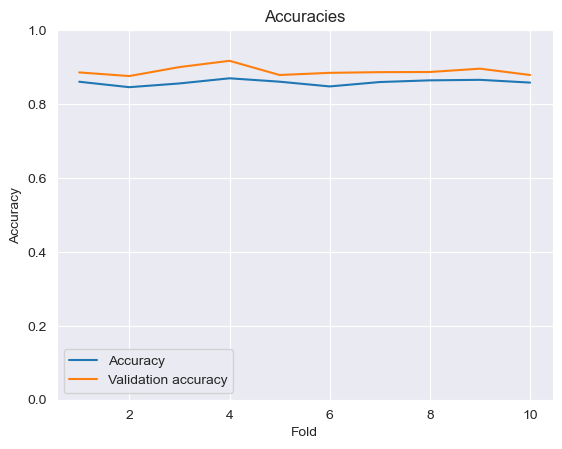

In [45]:
# Plot accuracies and validation accuracies per fold
import matplotlib.pyplot as plt
plt.title('Accuracies')
plt.plot(range(1, len(acc)+1), acc, label='Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
plt.ylim(0.0, 1.0)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [46]:
# Train a final model with same parameters and save it
train_generator = datagen.flow(x=X_train, y=y_train, batch_size=batch_size)
valid_generator = datagen.flow(x=X_val, y=y_val, batch_size=batch_size)
model = create_model()
history = model.fit(train_generator, validation_data=valid_generator, epochs=epochs, verbose=1, callbacks=[early_stop])
model.save('cnn.h5')

Epoch 1/7
157/157 [==============================] - 20s 121ms/step - loss: 0.6934 - accuracy: 0.5141 - auc: 0.5892 - val_loss: 0.6934 - val_accuracy: 0.5000 - val_auc: 0.4375
Epoch 2/7
157/157 [==============================] - 17s 106ms/step - loss: 0.5698 - accuracy: 0.6981 - auc: 0.7759 - val_loss: 0.6368 - val_accuracy: 0.5625 - val_auc: 0.8438
Epoch 3/7
157/157 [==============================] - 17s 106ms/step - loss: 0.3438 - accuracy: 0.8620 - auc: 0.9297 - val_loss: 0.4312 - val_accuracy: 0.8125 - val_auc: 0.9062
Epoch 4/7
157/157 [==============================] - 16s 104ms/step - loss: 0.2663 - accuracy: 0.8951 - auc: 0.9564 - val_loss: 0.4817 - val_accuracy: 0.7500 - val_auc: 0.8594
Epoch 5/7
157/157 [==============================] - 16s 103ms/step - loss: 0.2265 - accuracy: 0.9144 - auc: 0.9683 - val_loss: 0.5258 - val_accuracy: 0.6875 - val_auc: 0.8750
Epoch 6/7
157/157 [==============================] - 16s 103ms/step - loss: 0.1982 - accuracy: 0.9274 - auc: 0.9748 - va

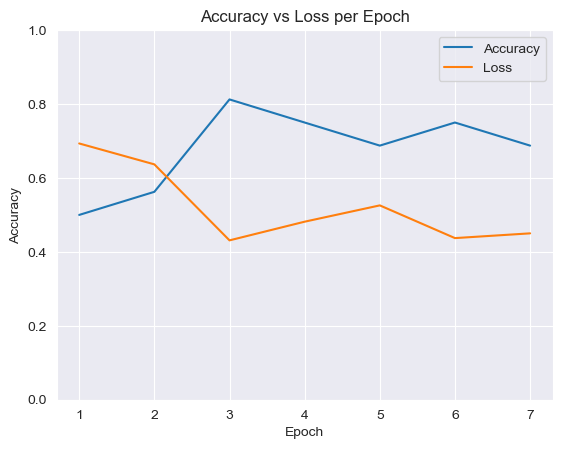

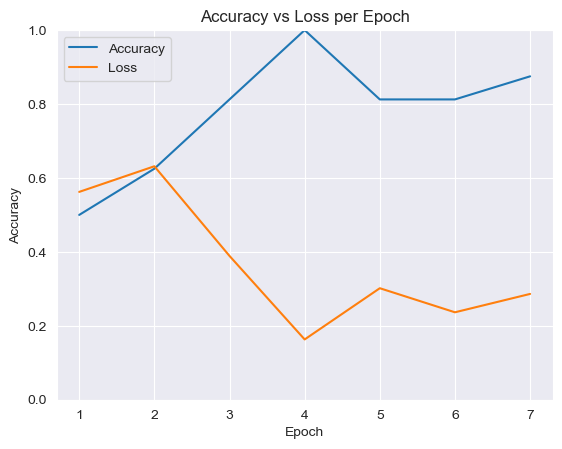

In [47]:
# Plot val accuracy and val loss of the trained model
import matplotlib.pyplot as plt
plt.title('Accuracy vs Loss per Epoch')
plt.plot(range(1, len(history.history["val_accuracy"])+1), history.history["val_accuracy"], label='Accuracy')
plt.plot(range(1, len(history.history["val_loss"])+1), history.history["val_loss"], label='Loss')
plt.ylim(0.0, 1.0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [48]:
# Make predictions on the test set
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test >= 0.5, 1, 0)

20/20 [==============================] - 0s 16ms/step


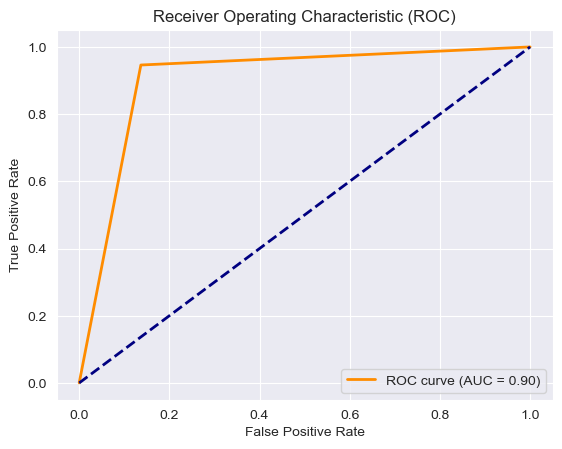

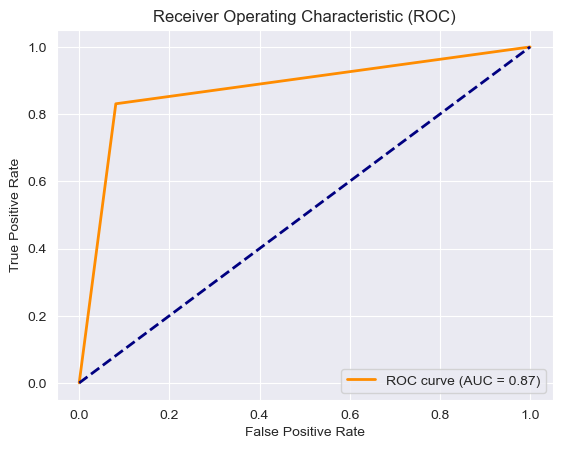

In [49]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and AUC score for the predictions
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# Plot ROC curve and show AUC score on the plot
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [50]:
from sklearn.metrics import confusion_matrix
# Compute the confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test.flatten())
print(cm)

[[202  32]
 [ 21 369]]
[[215  19]
 [ 66 324]]


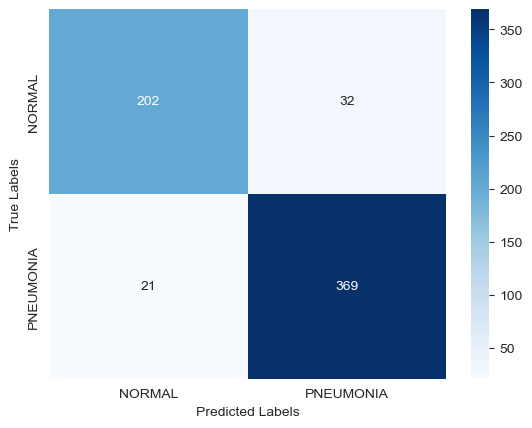

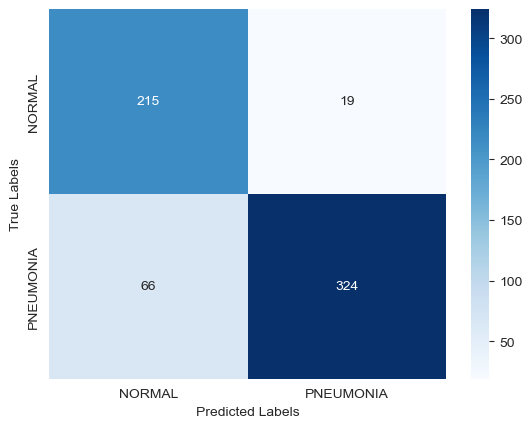

In [51]:
# Plot the confusion matrix
class_names = subfolders
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [52]:
# Compute the classification report for test set
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.91      0.86      0.88       234
   PNEUMONIA       0.92      0.95      0.93       390

    accuracy                           0.92       624
   macro avg       0.91      0.90      0.91       624
weighted avg       0.91      0.92      0.91       624

              precision    recall  f1-score   support

      NORMAL       0.77      0.92      0.83       234
   PNEUMONIA       0.94      0.83      0.88       390

    accuracy                           0.86       624
   macro avg       0.85      0.87      0.86       624
weighted avg       0.88      0.86      0.87       624



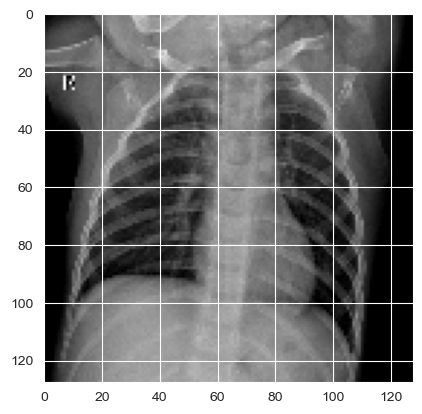

C:\ProgramData\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


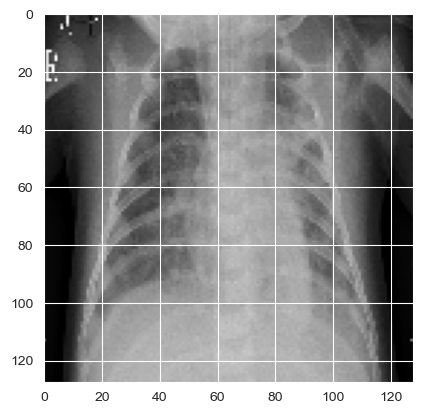

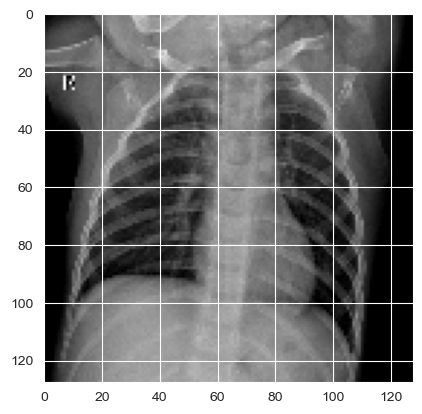

C:\ProgramData\anaconda3\lib\site-packages\keras\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


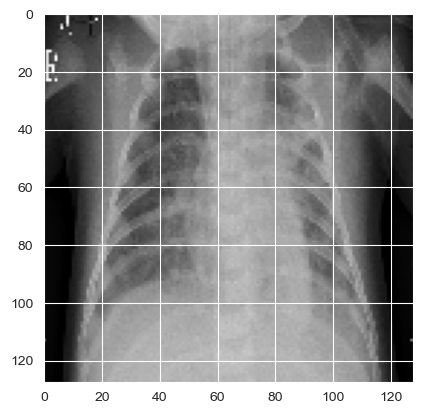

In [53]:
# Heatmaps and Grad-CAM
from common.cam import get_img_array
import cv2
import matplotlib.pyplot as plt 

images = [
    {
        "path": "./val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
    },
    {
        "path": "./val/PNEUMONIA/person1946_bacteria_4874.jpeg"
    }
]

for image in images:
    image_temp = cv2.imread(image["path"])
    image_temp = cv2.cvtColor(image_temp, cv2.COLOR_RGB2GRAY)
    image_temp = cv2.resize(image_temp, (img_width, img_height))

    plt.imshow(image_temp, cmap=plt.cm.gray)
    plt.show()
    
    image["array"] = get_img_array(image["path"], size=(img_width, img_height))
    

In [54]:
# Remove last layer's softmax
model.layers[-1].activation = None

# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [55]:
# Print model summary to get last max pooling layer name
print(model.summary())

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 126, 126, 128)     1280      
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 63, 63, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 61, 61, 256)       295168    
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 30, 30, 256)      0         
 g2D)                                                            
                                                                 
 conv2d_42 (Conv2D)          (None, 28, 28, 512)       1180160   
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 512)    

In [56]:
# Select last conv layer
last_conv_layer_name = "max_pooling2d_43"

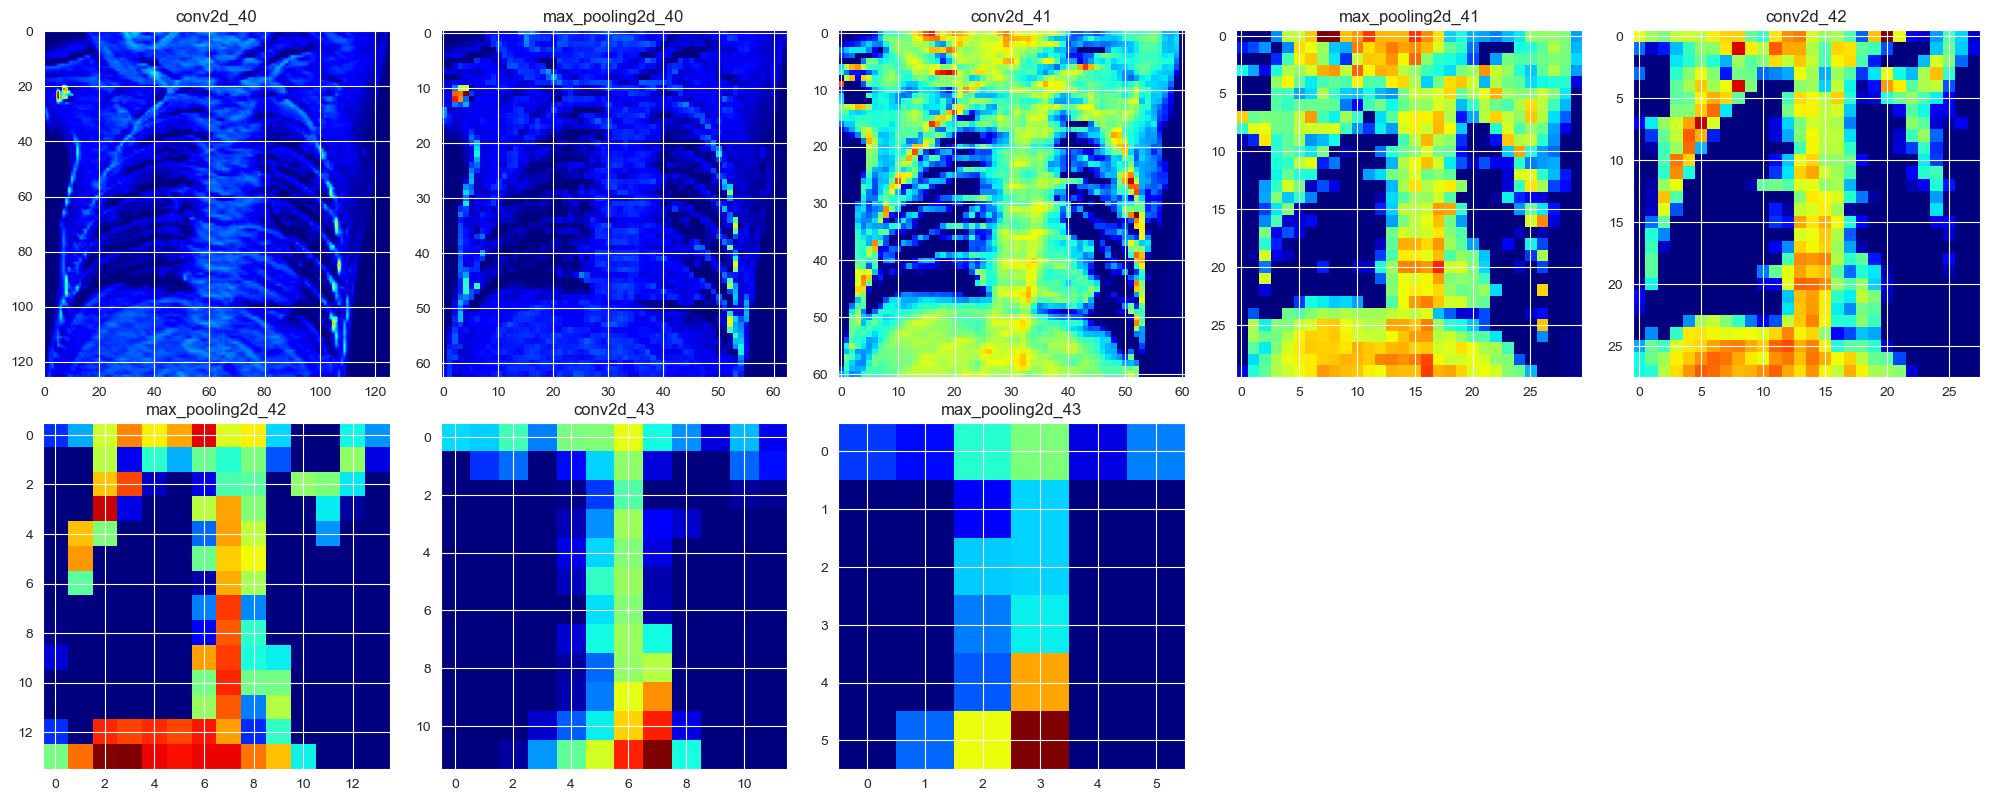

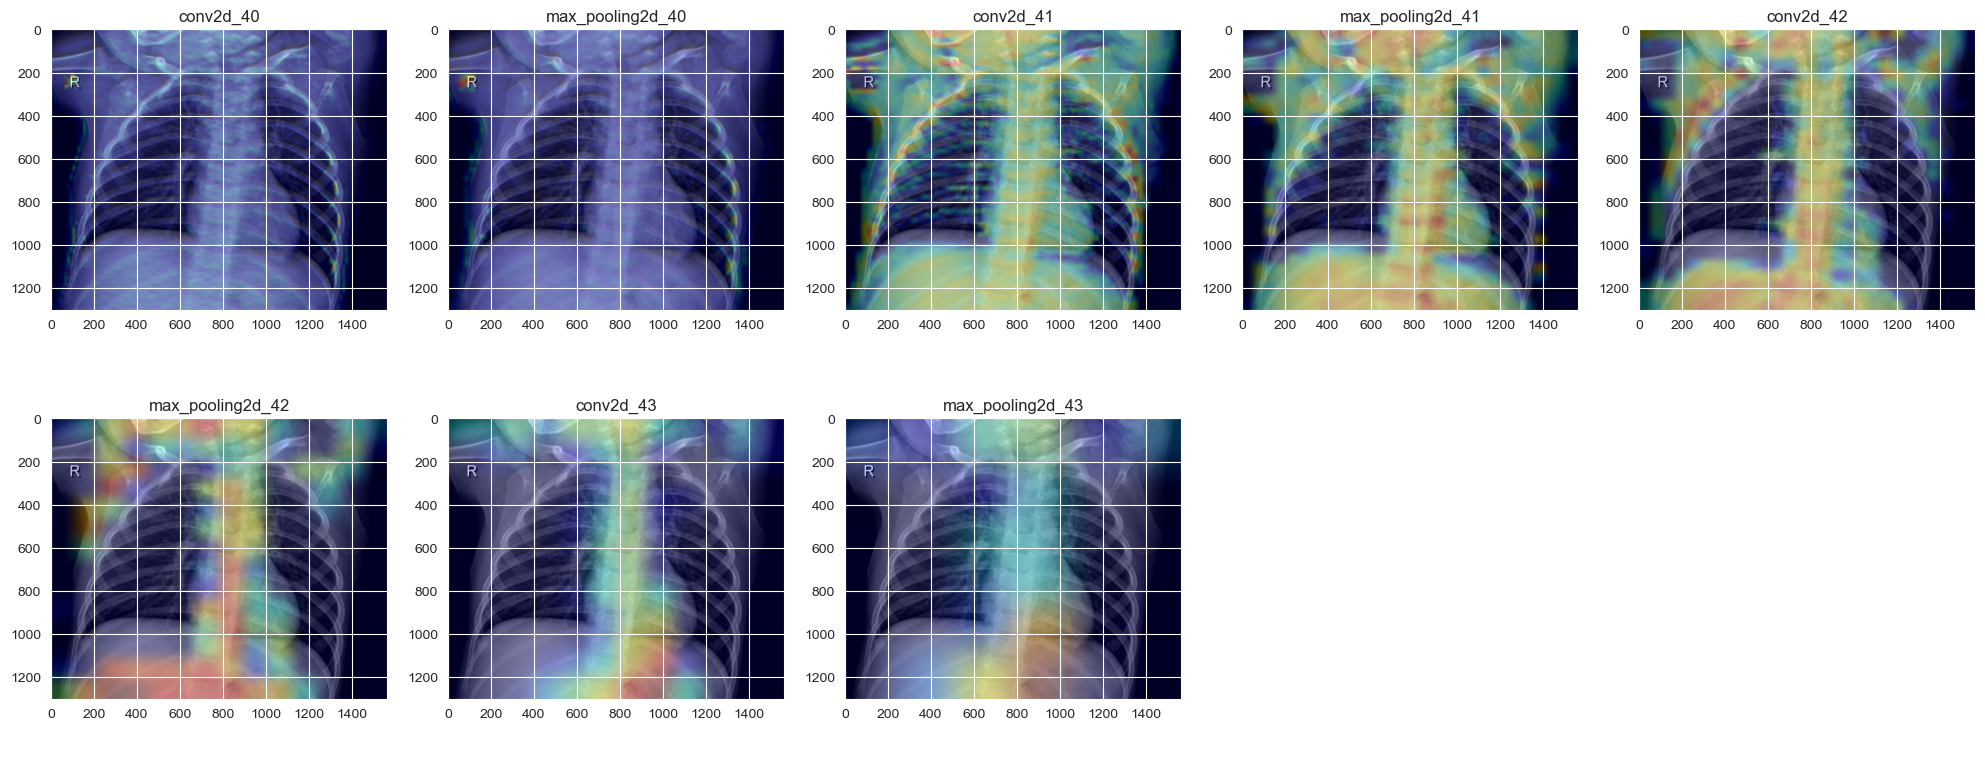

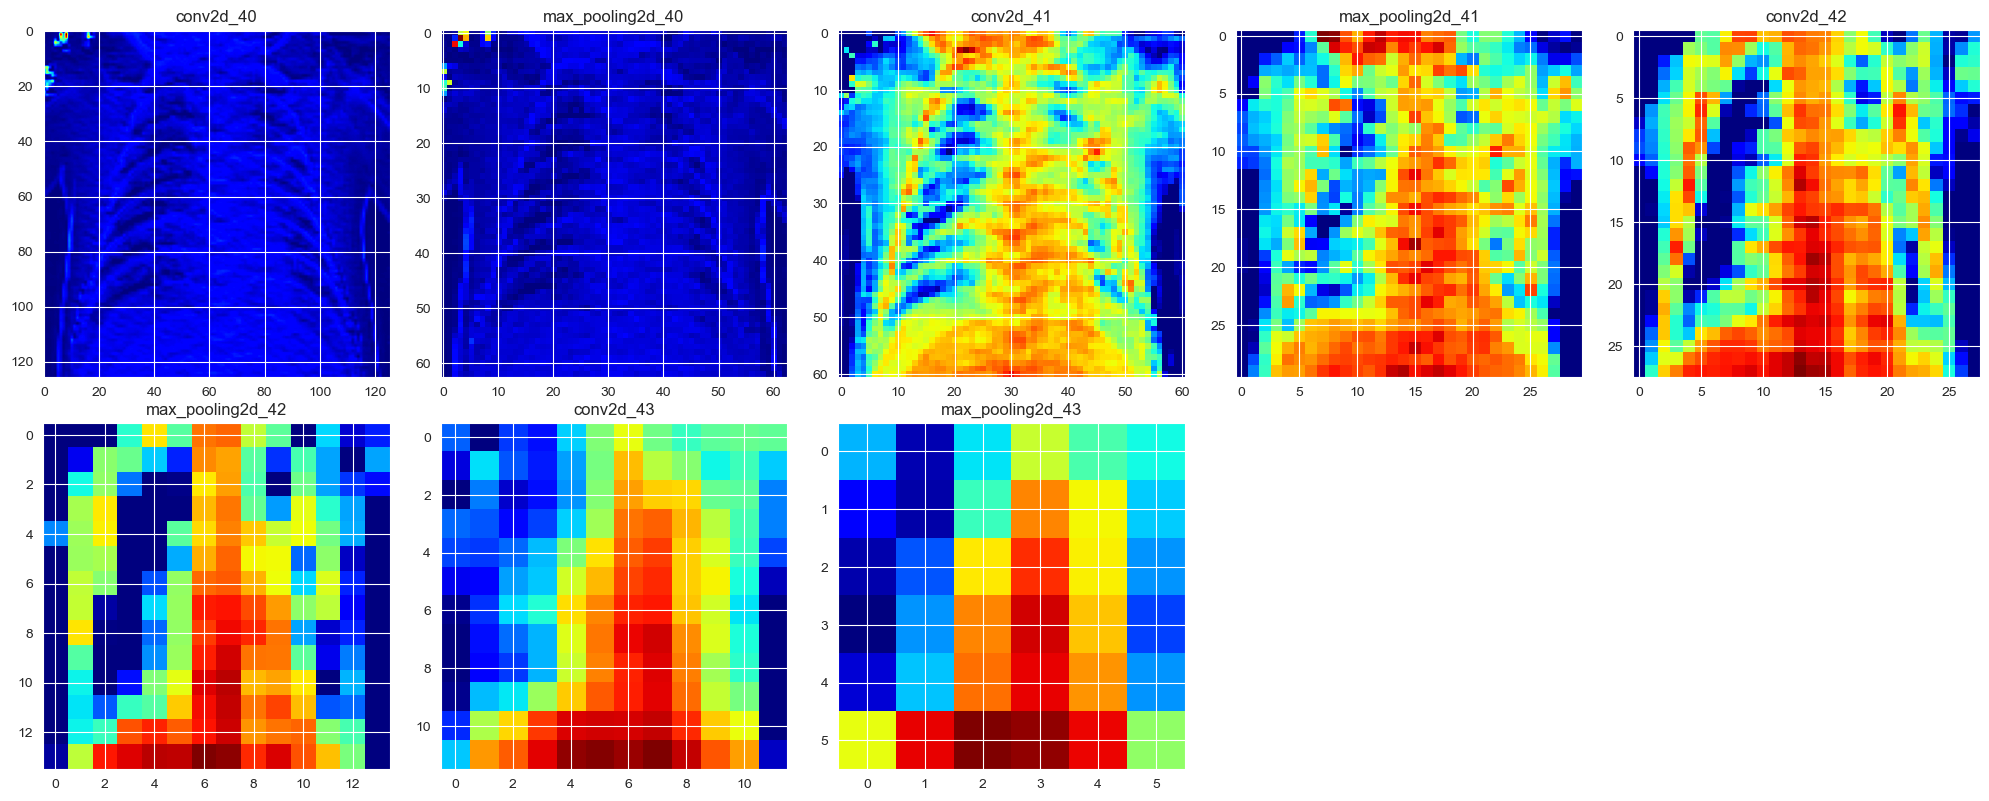

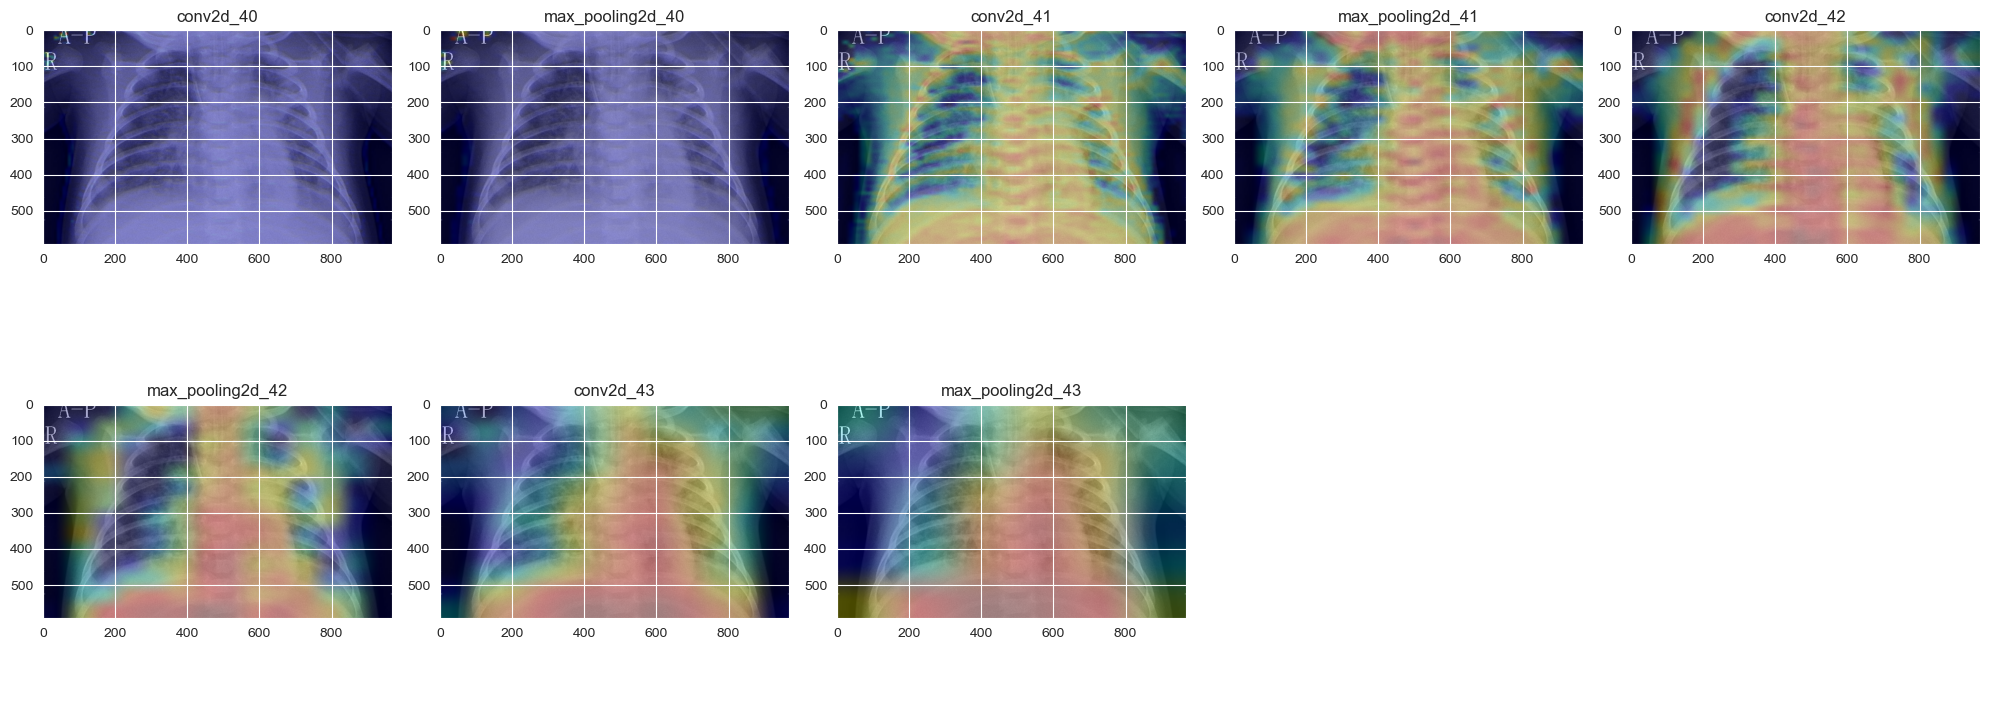

ValueError: No such layer: max_pooling2d_43. Existing layers are: ['conv2d_84', 'max_pooling2d_84', 'conv2d_85', 'max_pooling2d_85', 'conv2d_86', 'max_pooling2d_86', 'conv2d_87', 'max_pooling2d_87', 'flatten_21', 'dense_63', 'dropout_42', 'dense_64', 'dropout_43', 'dense_65'].

In [57]:
from common.cam import make_gradcam_heatmap, display_heatmaps

for image in images:
    heatmaps = []
    for layer in model.layers[:model.layers.index(model.get_layer(last_conv_layer_name)) + 1]:
        heatmap = make_gradcam_heatmap(image["array"], model, layer.name)
        heatmaps.append({
            "layer_name": layer.name,
            "image": heatmap
        })

    # Display heatmaps from all layers until the last max pooling layer
    display_heatmaps(image["path"], heatmaps)

    # Display the chosen image superimposed with heatmaps of each layer until the last max pooling layer
    display_heatmaps(image["path"], heatmaps, True)

In [ ]:
# Predict
for image in images:
    pred = model.predict(image["array"].reshape(1, img_width, img_height, 1))
    print(pred)
    # Display predicted class
    print("Predicted class: {}".format(subfolders[int(pred[0][0])]))

1/1 [==============================] - 1s 632ms/step
[[0.]]
Predicted class: NORMAL
1/1 [==============================] - 0s 25ms/step
[[1.]]
Predicted class: PNEUMONIA
